In [18]:
import numpy as np
import matplotlib.pyplot as plt
from math import expm1
from sasmodels.special import sas_2J1x_x, sas_sinx_x
from scipy.special import j0 as sas_J0x 
import pdb

In [19]:
def get_contrasts(d):
    rho_solv = 1

    if d==1:
        # Homogenous
        rho_s = rho_solv+1
        rho_c = rho_solv+1
    if d==2:
        # Shell
        rho_s = rho_solv
        rho_c = rho_solv+1
    if d==3:
        # core
        rho_s = rho_solv+1
        rho_c = rho_solv

    return rho_solv, rho_s, rho_c

# Example (units in Å)
Vc = 4000
Vs = 4000
R = 40
L = 100
N = 67
Rg = 10
d = 1.0
rho_solv, rho_s, rho_c = get_contrasts(2)
V_total = N*(Vs+Vc) 

params = {'v_core' : Vc,
         'v_corona' : Vs,
         'sld_solvent' : rho_solv,
         'sld_core' : rho_s,
         'sld_corona' : rho_c,
         'radius_core': R,
         'rg': Rg,
         'length_core': L,
         'd_penetration':d,
         'n_aggreg' : N,
         'v_total' : V_total 
         }

In [20]:
def orientational_average(f, alpha):
    dt = np.asarray([np.sin(ai) for ai in alpha])
    integrand = np.einsum('ij,j->ij', f, dt)

    return np.trapz(integrand, x = alpha, axis=1)

def psi(q, R, L, a):
    x = np.einsum('i,j->ij', q*R, np.sin(a))
    y = 0.5*np.einsum('i,j->ij', q*L, np.cos(a))

    t1 = sas_2J1x_x(x)
    t2 = sas_sinx_x(y)

    return t1*t2

def sigma(q, R, L, a):
    x = np.einsum('i,j->ij', q*R, np.sin(a))
    y = 0.5*np.einsum('i,j->ij', q*L, np.cos(a))

    t1 = (R/(R+L))*(sas_2J1x_x(x))*np.cos(y)
    t2 = (L/(R+L))*(sas_J0x(x))*(sas_sinx_x(y))

    return t1+t2 


In [21]:
def micelle_cylindrical_kernel(q,
        v_core=None,
        v_corona=None,
        v_total=None,
        sld_solvent=None,
        sld_core=None,
        sld_corona=None,
        radius_core=None,
        rg=None,
        length_core=None,
        d_penetration=None,
        n_aggreg=None):
    
    n_aggreg = (np.pi * radius_core**2 * length_core)/v_core
    print(n_aggreg)
    # n_aggreg = 67.0
    v_total = n_aggreg*(v_core+v_corona)
    rho_solv = sld_solvent     # sld of solvent [1/A^2]
    rho_core = sld_core        # sld of core [1/A^2]
    rho_corona = sld_corona    # sld of corona [1/A^2]

    beta_core = v_core * (rho_core - rho_solv)
    beta_corona = v_corona * (rho_corona - rho_solv)
    alpha = np.linspace(0, np.pi, num=1000)

    # Self-correlation term of the core
    bes_core = psi(q, radius_core, length_core, alpha)
    Fs = orientational_average(bes_core**2, alpha)
    term1 = np.power(n_aggreg*beta_core, 2)*Fs 

    # Self-correlation term of the chains
    qrg2 = np.power(q*rg, 2)
    debye_chain = 2.0*(np.vectorize(expm1)(-qrg2)+qrg2)/(qrg2**2) 
    debye_chain[qrg2==0.0] = 1.0
    term2 = n_aggreg * (beta_corona**2) * debye_chain

    # Interference cross-term between core and chains
    qrg = q*rg
    chain_ampl = -np.vectorize(expm1)(-qrg)/qrg
    chain_ampl[qrg==0.0] =  1.0 
    bes_corona = sigma(q,
                       radius_core+ d_penetration*rg,
                       length_core+ 2*d_penetration*rg,
                       alpha
                       )
    Ssc = chain_ampl*orientational_average(bes_core*bes_corona, alpha)
    term3 = 2.0 * (n_aggreg**2) * beta_core * beta_corona * Ssc

    # Interference cross-term between chains
    Scc = (chain_ampl**2)*orientational_average(bes_corona**2, alpha)
    term4 = n_aggreg * (n_aggreg - 1.0)* (beta_corona**2)*Scc

    # I(q)_micelle : Sum of 4 terms computed above
    i_micelle = term1 + term2 + term3 + term4 
    # print('Different terms : ', term1, term2, term3, term4)

    # Normalize intensity by total volume
    return i_micelle/v_total

[homogenous] :  1 2 2
125.66370614359172
[shell] :  1 1 2
125.66370614359172
[core] :  1 2 1
125.66370614359172


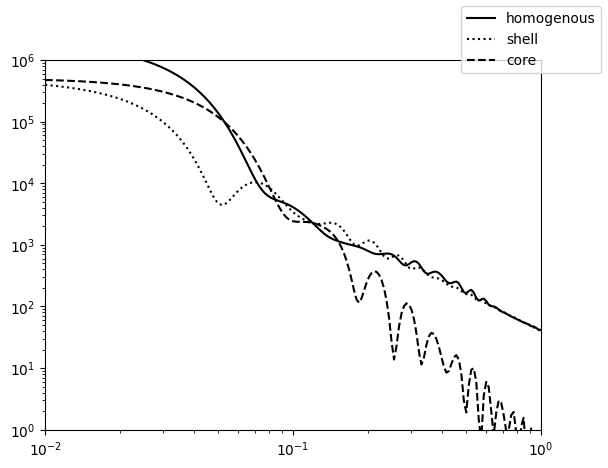

CPU times: user 783 ms, sys: 153 ms, total: 936 ms
Wall time: 439 ms


In [22]:
%%time
fig, ax = plt.subplots()
labels =['homogenous', 'shell', 'core']
linestyles = ['solid','dotted','dashed' ]
for i in range(3):
    rho_solv, rho_s, rho_c = get_contrasts(i+1)
    print('[%s] : '%labels[i], rho_solv, rho_s, rho_c)
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'v_total' : V_total,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'length_core': L,
            'd_penetration':d,
            'n_aggreg' : N,
            }
    q = np.logspace(np.log10(1e-2), np.log10(1), 200)
    Iq_micelle = micelle_cylindrical_kernel(q, **params)
    ax.loglog(q, Iq_micelle, label=labels[i], ls=linestyles[i], color='k')
    ax.set_ylim([1e0, 1e6])
    ax.set_xlim([1e-2, 1e0])
fig.legend()
plt.show()